In [359]:
import numpy as np
from math import cos, pi
import matplotlib.pyplot as plt

# Generate textfile

In [360]:
%run generate_text.py -n 160 -o text.txt

# Get text form file

In [361]:
path_text = "text.txt"
with open(path_text, "r") as file:
        text = file.read()
print(text)
text_length = len(text)

:yBQ2L+wAel*niI73R#T`b(R\{IPEq^|0ulgC&G#D_W|K>{Ur;WTuz?{G8&O$&Vg;<dG2|8Fh40_Gyg4Nw^tLK8:F3_tD9[;SGNi6#+V@/p9U#HgKHGrnk~L&[a1qi2v*V)7t6;`)@>mjb9e0[^>N&D#}uY3veK8


# Convert text to binary

In [362]:
barker1 = [1,1,1,1,1,0,0,1,1,0,1,0,1]*5
barker2 = [1,1,1,0,0,1,0]*5


""""barker1 = np.random.normal(0.0, 1, size=5*text_length)
barker1[barker1 <= 0] = 0
barker1[barker1 > 0] = 1
barker1 = barker1.tolist()
barker2 = np.random.normal(0.0, 1, size=5*text_length)
barker2[barker2 <= 0] = 0
barker2[barker2 > 0] = 1
barker2 = barker2.tolist()"""


def to_binary(text):
    """
    Convert the text to a binary array. Each character is converted
    to its ASCII binary representation. 13-Length barker code are
    appended at the beginning and the end of the signal.
    
    :param text: string containing the text we want to send
    :return binary: numpy array containing the binary form of the text
    """
    binary = barker1[:]

    for c in text:
        ascii_val = ord(c)
        bits = bin(ascii_val)[2:]
        padding = "0"*(7-len(bits))
        bits = padding + bits
        bits = [int(b) for b in bits]
        binary.extend(bits)

    binary.extend(barker2)
    binary = np.array(binary)

    return binary

In [363]:
binary_text_with_barker = to_binary(text)
binary_text = binary_text_with_barker[len(barker1):-len(barker2)]

# Convert binary to waveform

In [364]:
Fs = 22050
nbr_sample = 100
t = np.arange(nbr_sample)
f00 = 2000
f01 = 4000
f10 = 6000
f11 = 8000

In [365]:
def base0(t):
    return 0.5*(cos(2*pi*f00*t/Fs)+cos(2*pi*f01*t/Fs))

def base1(t):
    return 0.5*(cos(2*pi*f10*t/Fs)+cos(2*pi*f11*t/Fs))

def bit_to_wave(b):
    """
    Converts one bit to its signal form sampled between 0 and 100/Fs
    
    :param b: the bit we want to convert
    :return: the sampled signal corresponding either to base0 or base1
    """
    if b == 0:
        f = np.vectorize(base0)
        return f(t)
    elif b == 1:
        f = np.vectorize(base1)
        return f(t)

signals = bit_to_wave(binary_text_with_barker[0])
for b in binary_text_with_barker[1:]:
    signals = np.hstack((signals, bit_to_wave(b)))

print("Size of the signal",signals.size)

Size of the signal 122000


In [366]:
barker_wave1 = signals[:nbr_sample*len(barker1)]
barker_wave2 = signals[-nbr_sample*len(barker2):]
signal_path = "signal.txt"
np.savetxt(signal_path, signals)

# Send signal to the server

In [367]:
%run pdc_project_channel_access/client.py --input_file=signal.txt --output_file=recv.txt --srv_hostname=iscsrv72.epfl.ch --srv_port=80

print("Siganl saved at recv.txt")

Siganl saved at recv.txt


# Load signal from file

In [368]:
recv_path = "recv.txt"
filtered_signal = np.loadtxt(recv_path)

# Synchronization

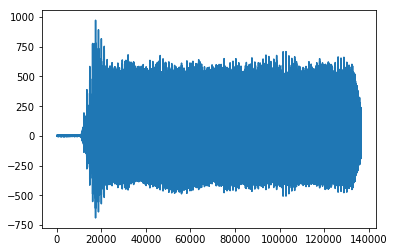

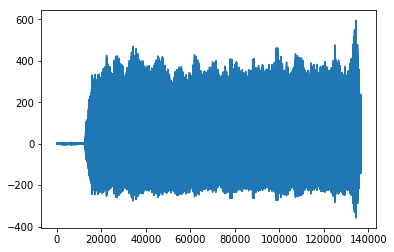

Size of the synchronized received signal 111989


In [369]:
recv_path = "recv.txt"
filtered_signal = np.loadtxt(recv_path)

#compute autocorrelation
auto1 = np.correlate(filtered_signal, barker_wave1, mode='same')
auto2 = np.correlate(filtered_signal, barker_wave2, mode='same')

plt.plot(np.arange(auto1.size), auto1)
plt.show()
plt.plot(np.arange(auto2.size), auto2)
plt.show()

x0 = np.argmax(auto1) + barker_wave1.size//2
xe = np.argmax(auto2) - barker_wave2.size//2
print("Size of the synchronized received signal", xe-x0)
filtered_signal = filtered_signal[x0:xe+1]

# Decode

In [370]:
def signal_to_binary(filtered_signal):
    nbr_chars = filtered_signal.size//nbr_sample

    bits = []
    for i in range(nbr_chars):
        s = filtered_signal[i*nbr_sample:(i+1)*nbr_sample]
        fft = np.fft.fft(s)
        b = 0 if np.argmax(fft)*Fs/nbr_sample < 5000 else 1
        bits.append(b)
    return bits

In [371]:
decoded_binary = signal_to_binary(filtered_signal)

# Convert binary back to text

In [372]:
def binary_to_text(bits):
    bits = [bits[i:i+7] for i in range(0, len(bits),7)]
    bits = [''.join([str(b) for b in bs]) for bs in bits]
    return bits

In [373]:
decoded_text = binary_to_text(decoded_binary)
decoded_text = [chr(int(x,2)) for x in decoded_text]
recovered_text = ''.join(decoded_text)
print(recovered_text)

8y gAhNA&#BP``  {A qx eHgC#@_|
>{b;@qx?{F0&$$VG2<@F0|8Fh00yF$w\`LC803_p 1S;CH&# /p1Q@GCGbNc|`1qi0d  '`$;`	@>IBb9D0>& yeX3vaK


# Compute error rate

In [374]:
nbr_error = np.sum(np.abs(np.array(decoded_binary)-binary_text))
error_rate = nbr_error/len(decoded_binary)
print(error_rate)

ValueError: operands could not be broadcast together with shapes (1119,) (1120,) 